# Chat With Tools

In [ ]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings, ChatHuggingFace
from langchain.tools import tool

from langchain.schema import AIMessage, HumanMessage
from langchain_core.messages import SystemMessage, AnyMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import RunnableConfig, Runnable
from langchain_core.tools import BaseTool
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages

from typing import Annotated, Any, Dict, Optional, TypedDict, Union, List
from lightning import Fabric

from IPython.display import display, Markdown, Image, SVG
from os import walk

/home/yuaylong/miniconda3/envs/nlp/lib/python3.12/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: '__init_subclass__' (from 'transformers.agents.tools') is deprecated and will be removed from version '4.51.0'. Switch to smolagents instead, with the same functionalities and similar API (https://huggingface.co/docs/smolagents/index)
  warnings.warn(warning_message, FutureWarning)


### Set mixed precision

In [2]:
torch.set_float32_matmul_precision("medium")
fabric = Fabric(accelerator="cuda", devices=1, precision="bf16-mixed")
device = fabric.device
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


## RAG

### Load Embedding Data

In [3]:
embed_model_name = "sentence-transformers/all-mpnet-base-v2"

embeddings = HuggingFaceEmbeddings(model_name=embed_model_name)

### Load vector store

In [4]:
vector_store = FAISS.load_local(
    "./faiss_spell_index",
    embeddings=embeddings,
    allow_dangerous_deserialization=True
)
retriever = vector_store.as_retriever()

## Functions

In [5]:
@tool
def spell_retrieve(query: str) -> str:
    """Retrieve information about dungeons and dragons spell.
    
    Args:
        query (str): The spell name to search for.

    Returns:
        str: The spell information.
    """
    retrieved_docs = vector_store.similarity_search(query, k=3)

    contents = "\n\n".join(
        (f"{doc.page_content}")
        for doc in retrieved_docs
    )
    
    return contents

@tool
def user(name: str) -> str:
    """
    User infomation retreiver

    Args:
        name (str): The name of user.

    Returns:
        str: The user information.
    """
    return f'Hi, {name}.'

tools = [
    spell_retrieve,
    user
]

## Workflow

```
[User Message] 
     ↓
[xLAM-2] → [Check if Tool Call is Required] 
     ├── No → [Return to Llama 3 with "No tool needed"]
     └── Yes → [Detect Tool to Call] → [Prepare Structured Tool Call] → [Execute Tool] → [Send Result to Llama 3]
                          ↓
               [Llama 3] → [Generate Final Natural Reply]
     ↓
[Final reply to User]
```

## Custom Sate

In [6]:
class State(TypedDict):
    name: str
    messages: Annotated[list[AnyMessage], add_messages]
    context: str

## Tool Calling Class

In [7]:
class ToolCallRequest(TypedDict):
    """A typed dict that shows the inputs into the invoke_tool function."""

    name: str
    arguments: Dict[str, Any]

In [8]:
class ToolCalling():
    def __init__(self, model_name: str, tools: list[BaseTool]):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cpu")
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=512,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)
        self.rendered_tools = [convert_to_openai_tool(f) for f in tools]

    def invoke_tool(
            self,
            tool_call_request: Union[ToolCallRequest, List[ToolCallRequest]], 
            config: Optional[RunnableConfig] = None
    ):
        """A function that we can use the perform a tool invocation.

        Args:
            tool_call_request: a dict that contains the keys name and arguments.
                The name must match the name of a tool that exists.
                The arguments are the arguments to that tool.
            config: This is configuration information that LangChain uses that contains
                things like callbacks, metadata, etc.See LCEL documentation about RunnableConfig.

        Returns:
            output from the requested tool
        """

        print("Tool call request:", tool_call_request)
        
        # Sometimes the model outputs a list of tool call requests, 
        # so I loop each tool call and append to list
        
        if isinstance(tool_call_request, list):
            output = list()

            for tool_call in tool_call_request:
                tool_name_to_tool = {tool.name: tool for tool in tools}
                name = tool_call["name"]
                requested_tool = tool_name_to_tool[name]
                output.append(requested_tool.invoke(tool_call["arguments"], config=config))
            return output
        
        tool_name_to_tool = {tool.name: tool for tool in tools}
        name = tool_call_request["name"]
        requested_tool = tool_name_to_tool[name]
        return requested_tool.invoke(tool_call_request["arguments"], config=config)
    
    def invoke(self, state: State) -> List[str]:
        system_prompt = SystemMessage(f"""\
        You are an assistant that has access to the following set of tools. 
        Here are the names and descriptions for each tool:

        {self.rendered_tools}

        Given the user input, return the name and input of the tool to use. 
        Return your response as a JSON blob with 'name' and 'arguments' keys.

        The `arguments` should be a dictionary, with keys corresponding 
        to the argument names and the values corresponding to the requested values.
        """)

        chain = self.chat | JsonOutputParser() | self.invoke_tool
        messages = [system_prompt] + [state['messages'][-1]]

        try:
            response = chain.invoke(messages)
        except Exception as e:
            print("Error invoking tool:", e)
            response = ["No tool needed"]

        if not response:
            response = ["No tool needed"]
        
        return {"context": AIMessage(response)}

### ToolCalling Class Usage

In [9]:
tool_calling_model_name = "Salesforce/Llama-xLAM-2-8b-fc-r"

tool_calling = ToolCalling(
    model_name=tool_calling_model_name,
    tools=tools
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cpu


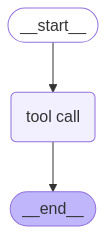

Tool call request: [{'name': 'spell_retrieve', 'arguments': {'query': 'Fireball'}}]


{'name': 'player_3',
 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='93d70794-949a-4b34-89b2-63ed6476aecf')],
 'context': AIMessage(content=["# Fireball\n## Spell Name\nFireball  \nFrom Player's Handbook, page 241.\n## Description\n![](https://static.wikia.nocookie.net/dnd-5e/images/a/ae/Fireball.png/revision/latest/scale-to-width-down/235?cb=20221208110401)\n![](https://static.wikia.nocookie.net/dnd-5e/images/a/ae/Fireball.png/revision/latest/scale-to-width-down/235?cb=20221208110401)  \n*3rd-level evocation*\n* **Casting Time:** 1 action\n* **Range:** 150 feet\n* **Components:** V, S, M (a tiny ball of bat guano and sulfur)\n* **Duration:** Instantaneous\n\n**Components:**\n- **Duration:** Concentration, up to 1 minute\n**Duration:**\nA 5-foot-diameter sphere of fire appears in an unoccupied space of your choice within range and lasts for the duration. Any

In [10]:
def tool(state: State) -> str:
    return tool_calling.invoke(state)

graph = StateGraph(State)
graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)
graph.add_edge("tool call", END)

graph = graph.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

input_message = {
    "name": "player_3",
    "messages": [HumanMessage(content="<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>")],
    "context": ""
}

graph.invoke(input_message)

## Llama-3 Chat Class

In [11]:
class LlamaChat():
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, load_in_4bit=True)
        self.pipe = pipeline(
            task="text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            return_full_text=False,
            max_new_tokens=2048,
            top_k=10,
            device_map="auto"
        )
        self._llm = HuggingFacePipeline(pipeline=self.pipe)
        self.chat = ChatHuggingFace(llm=self._llm, tokenizer=self.tokenizer)

    def generate(self, state: State) -> Dict[str, Any]:
        system_message_content = (
            "<|start_header_id|>system<|end_header_id|>\n"
            "In a text-based adventure (Dungeons and Dragons), your job is to narrate the adventure "
            "and respond to the player's actions.\n"
            "Use the following pieces of retrieved context to answer the question.\n"
            "If you don't know the answer, say i dont know."
            "If the player breaks the game rules, "
            "notify the player.\n"
            "This is the retrieved context:\n\n"
            f"{state['context']}\n\n"
            "When you answer the player, you must respond in proper markdown format: heading, table, bold, italic, paragraph, blockquotes.\n"
        )

        print('State:', state)
        print('Context:', state["context"])
        print('Generating response ...')

        conversation_messages = [
            message
            for message in state["messages"]
            if message.type in ("human", "system")
            or (message.type == "ai" and not message.tool_calls)
        ]

        prompt = [SystemMessage(system_message_content)] + conversation_messages

        response = self.chat.invoke(prompt)
        
        return {"messages": [response]}

### LlamaChat Class Usage

In [12]:
llama_model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

llama = LlamaChat(model_name=llama_model_name)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [13]:
prompt = (
            "<|start_header_id|>system<|end_header_id|>\n"
            "You are tasked with generating a relevant command for a tool-calling model.\n" \
            "Your answer should be a simple sentence.\n" \
        )
text = "<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": "You are inside a dark dungeon filled with goblins. Fireball is a high-damage spell."
}

response = llama.generate(state=input_state)
print(response)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>', additional_kwargs={}, response_metadata={})], 'context': 'You are inside a dark dungeon filled with goblins. Fireball is a high-damage spell.'}
Context: You are inside a dark dungeon filled with goblins. Fireball is a high-damage spell.
Generating response ...
{'messages': [AIMessage(content="**What's the situation?**\nYou're currently standing in a dark dungeon, surrounded by goblins. You've got your trusty spellbook and a few spells up your sleeve. The goblins are closing in, and you need to decide what to do next.\n\n**What's your current situation?**\n\n| **Health** | **Mana** | **Location** |\n| --- | --- | --- |\n| 100 | 80 | Dark Dungeon |\n\n**What do you want to do?**\n\nYou can cast Fireball, but keep in mind it'll use up a lot of mana and might not be the most strategic choice in this situation. What's your move?", addit

## LangGraph Demo

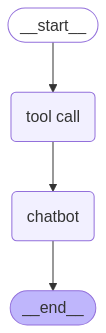

In [16]:
def tool(state: State):
    return tool_calling.invoke(state)

def chatbot(state: State) -> str:
    return llama.generate(state=state)

graph = StateGraph(State)

graph.add_edge(START, "tool call")
graph.add_node("tool call", tool)

graph.add_edge("tool call", "chatbot")

graph.add_node("chatbot", chatbot)
graph.add_edge("chatbot", END)

graph = graph.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
text = "<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>"

input_state = {
    "name": "player_1",
    "messages": [
        HumanMessage(content=text)
    ],
    "context": ""
}

response = graph.invoke(input_state)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Tool call request: [{'name': 'spell_retrieve', 'arguments': {'query': 'Fireball'}}]
State: {'name': 'player_1', 'messages': [HumanMessage(content='<|start_header_id|>player_3<|end_header_id|>\nWould you like me to cast Fireball?<|eot_id|>', additional_kwargs={}, response_metadata={}, id='c4192f88-1b49-43fc-a2b5-37f209b27997')], 'context': AIMessage(content=["# Fireball\n## Spell Name\nFireball  \nFrom Player's Handbook, page 241.\n## Description\n![](https://static.wikia.nocookie.net/dnd-5e/images/a/ae/Fireball.png/revision/latest/scale-to-width-down/235?cb=20221208110401)\n![](https://static.wikia.nocookie.net/dnd-5e/images/a/ae/Fireball.png/revision/latest/scale-to-width-down/235?cb=20221208110401)  \n*3rd-level evocation*\n* **Casting Time:** 1 action\n* **Range:** 150 feet\n* **Components:** V, S, M (a tiny ball of bat guano and sulfur)\n* **Duration:** Instantaneous\n\n**Components:**\n- **Duration:** Concentration, up to 1 minute\n**Duration:**\nA 5-foot-diameter sphere of fire a

In [21]:
response['messages'][-1].content

"**What is your target for the Fireball spell?**\nYou're considering casting Fireball! That's a powerful spell that can deal significant damage to your enemies. Before you cast it, you need to decide where to aim it.\n\nYou can specify a location, a creature, or a group of creatures within the 150-foot range. Keep in mind that the spell's effects will be instantaneous, so choose wisely!"